# Repository Discovery

It is difficult, without specialized knowledge or dedicated inspection, to determine how repos on Github are related to one another.

Which projects (repos) are trying to solve the same problem? Which are in the same ecosystem? Which pre-date which others?

We've begun to study this problem using the abstract model of networks. Our approach is summarized by the neuroscience Hebbian mneumonic approximation: "fire together, wire together."
Said with greater context, groups of projects that share features (contributors, in this first exploration) are more likely than others to do similar things.

We expect projects in the container orchestration space to, pairwise, share more contributors together than with projects outside of that context, on average.

## This notebook's contribution

In this notebook, we attempt to solve a challenging problem:

**Given the contributors in a known kernel of projects within the same domain, identify relevant, previously censored, repos that those contributors have also taken part in.**

Similarly,

**Given a list of newly discovered potential ecosystem member repositories, identify those that are the most preeminent, filtering out those that are natural 'noise,' irrelevant to the studied ecosystem.**

# Setup

Import Python packages, load database access credentials, define connection to DB.

In [274]:
#IMPORTS
import pandas as pd
import sqlalchemy as salc
import plotly.express as px
import pyarrow
import json
import uuid
from IPython.display import Image

In [275]:
#DATABASE ACCESS

with open("wasm_creds.json") as config_file:
    config = json.load(config_file)

database_connection_string = f"postgresql+psycopg2://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': f"-csearch_path={'augur_data'}"})

In [276]:
# SWITCHES

LOCAL_DATA = True 

# Known contributors

At the outset, we identified a kernel of projects that we are highly confident exist within our ecosystem of interest.

**NOTE:** We refer to 'kernel' here as an abstract mathematical centerpoint of our analysis. We aren't referring to the software artifact at the center of an operating system.

From this kernel of projects, we identified all of the contributors and ranked them based on how they interacted with one another.

Those who interact with many others in a valuable way are more highly ranked than those who never interact whatsover, and soforth.

The data below is the artifact from that analysis, where each row is: {contributor_id, contributor_importance_ranking}

---

For reference, this work is at the following absolute path in this repository:

`Rappel/notebooks/8knot/collab_network/wasm/collabs.ipynb`

In [277]:
df_known_contribs = pd.read_csv('contrib_pagerank_scores.csv')
df_known_contribs = df_known_contribs.rename(columns={"contrib_id": "cntrb_id"})
df_known_contribs.head()

,cntrb_id,normalized_pagerank_score
0,010002df-6100-0000-0000-000000000000,20.000000
1,010000fd-e400-0000-0000-000000000000,19.052353
2,01002a5e-b400-0000-0000-000000000000,17.138503
3,0100034c-5400-0000-0000-000000000000,16.901099
4,01003291-1b00-0000-0000-000000000000,16.831682


# Contribution event stream

Github provides an API endpoint from which one can query every event that occurs. For instance, if a contributor creates an issue on some repo, that event will be logged in the stream. A downside of this API is that it only serves the most recent two months of data. 

We want to use this stream to identify the set of repositories that our Known Contributors are also working in that weren't in the initial ecosystem kernel.

The database that we use collects this event stream so we can query it from there rather than from Github. This is much faster than relying on the public Github API, and we will continue to collect the data that the API makes available, so over time the analysis that we can do will become richer and more complete. In the Augur database, the table with this information is the 'contributor_repo' table.

In [278]:
event_stream_query = salc.sql.text(
    f"""
        SET SCHEMA 'augur_data';
        SELECT 
            c.cntrb_id,
            c.event_id,
            c.created_at,
            c.cntrb_repo_id as repo_id,
            c.repo_git,
            c.repo_name,
            c.gh_repo_id,
            c.cntrb_category as event_type
        FROM
        contributor_repo c
    """)


if not LOCAL_DATA:
    with engine.connect() as conn:
        df_event_stream = pd.read_sql_query(event_stream_query, conn)
        
    with open("df_event_stream.parquet", "wb+") as f:
        df_event_stream.cntrb_id = df_event_stream.cntrb_id.astype(str)
        df_event_stream.to_parquet(f)
else:
    with open("df_event_stream.parquet", "rb+") as f:
        df_event_stream = pd.read_parquet(f)

## Event stream data

Below we see a summary of the data we have:

- 4.2 million events,

In [279]:
df_event_stream.describe()

,event_id,repo_id,gh_repo_id
count,4.243500e+06,4.243500e+06,4.243500e+06
mean,3.099347e+10,2.605484e+07,3.426358e+08
std,8.819875e+08,2.807511e+07,2.368784e+08
min,2.888731e+10,1.000000e+00,1.000000e+00
25%,3.043546e+10,1.064824e+06,1.134863e+08
50%,3.108294e+10,8.449530e+06,3.329603e+08
75%,3.175927e+10,5.043982e+07,5.851464e+08
max,3.225873e+10,1.018265e+08,6.995313e+08


### Head of dataframe

In [280]:
df_event_stream.head()

,cntrb_id,event_id,created_at,repo_id,repo_git,repo_name,gh_repo_id,event_type
0,0100f4d9-0a00-0000-0000-000000000000,29206154815,2023-05-21 12:46:42,1331068,https://api.github.com/repos/mydeveloperday/sp...,mydeveloperday/spectral-sarif,643239814,PushEvent
1,01010bc1-fd00-0000-0000-000000000000,29266421350,2023-05-23 20:50:08,828122,https://api.github.com/repos/HazardyKnusperkek...,HazardyKnusperkeks/units,351321247,PushEvent
2,0100e8ca-1300-0000-0000-000000000000,32035370577,2023-09-22 14:59:22,50867574,https://api.github.com/repos/prometheus-operat...,prometheus-operator/prometheus-operator,68964263,ForkEvent
3,01010bc1-fd00-0000-0000-000000000000,29264457425,2023-05-23 19:13:06,828123,https://api.github.com/repos/llvm/llvm-project,llvm/llvm-project,75821432,IssueCommentEvent
4,0101b71a-0d00-0000-0000-000000000000,31189643965,2023-08-17 15:49:35,36340270,https://api.github.com/repos/Homebrew/homebrew...,Homebrew/homebrew-core,52855516,IssueCommentEvent


### Most common types of events

In [281]:
event_counts = df_event_stream.event_type.value_counts()
event_counts

PushEvent                        1504163
IssueCommentEvent                 614512
PullRequestEvent                  428910
PullRequestReviewEvent            363215
CreateEvent                       328443
PullRequestReviewCommentEvent     277490
WatchEvent                        240648
DeleteEvent                       206104
IssuesEvent                       177787
ForkEvent                          43458
CommitCommentEvent                 22144
ReleaseEvent                       21659
GollumEvent                         7224
MemberEvent                         4389
PublicEvent                         3354
Name: event_type, dtype: int64

In [282]:
fig_ec = px.bar(
    data_frame=event_counts.to_frame(),
    color=event_counts.to_frame().index,
)
fig_ec.update_layout(showlegend=False)

fig_ec.write_image("general_eventcount.png")
fig_ec

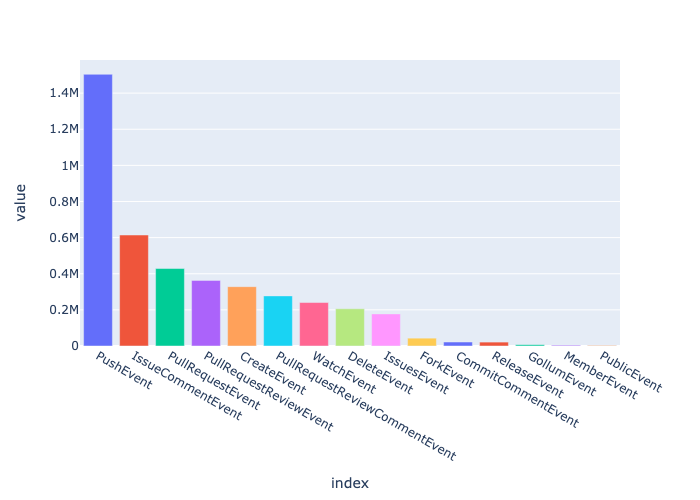

In [283]:
Image("general_eventcount.png")

### Repositories with the most events 

In [284]:
repo_event_counts = df_event_stream.repo_git.value_counts()
repo_event_counts

https://api.github.com/repos/llvm/llvm-project                          49315
https://api.github.com/repos/JetBrains/MPS                              14522
https://api.github.com/repos/dotnet/runtime                             14115
https://api.github.com/repos/pytorch/pytorch                            14024
https://api.github.com/repos/rust-lang/rust                             13521
                                                                        ...  
https://api.github.com/repos/thunderbolt181/FileShare                       1
https://api.github.com/repos/Sir-hennihau/react-native-web-turborepo        1
https://api.github.com/repos/josephrocca/diy-perchance-api                  1
https://api.github.com/repos/huggingface/m4-logs                            1
https://api.github.com/repos/decaffeinate/decaffeinate-project.org          1
Name: repo_git, Length: 324583, dtype: int64

In [285]:
df_fig_rec = repo_event_counts.to_frame().rename(columns={"repo_git": "count"})
print(df_fig_rec)
df_fig_rec = df_fig_rec[df_fig_rec["count"] > 2500]

fig_rec = px.bar(
    data_frame=df_fig_rec,
    color=df_fig_rec.index,
)
fig_rec.update_layout(showlegend=False)
fig_rec.write_image("general_repository_eventcount.png")
fig_rec

                                                    count
https://api.github.com/repos/llvm/llvm-project      49315
https://api.github.com/repos/JetBrains/MPS          14522
https://api.github.com/repos/dotnet/runtime         14115
https://api.github.com/repos/pytorch/pytorch        14024
https://api.github.com/repos/rust-lang/rust         13521
...                                                   ...
https://api.github.com/repos/thunderbolt181/Fil...      1
https://api.github.com/repos/Sir-hennihau/react...      1
https://api.github.com/repos/josephrocca/diy-pe...      1
https://api.github.com/repos/huggingface/m4-logs        1
https://api.github.com/repos/decaffeinate/decaf...      1

[324583 rows x 1 columns]


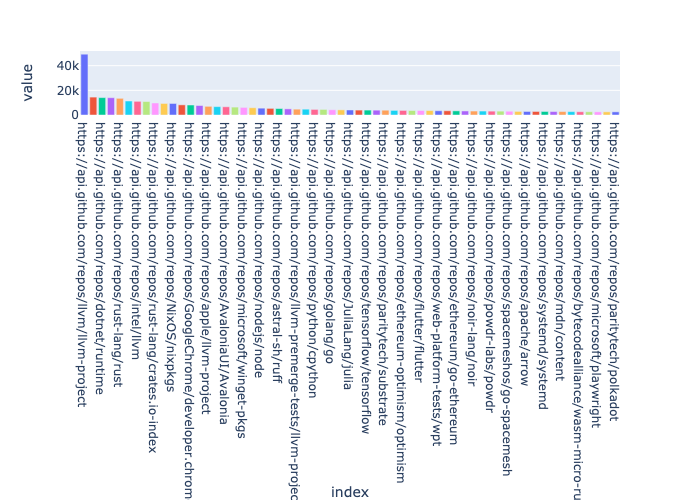

In [286]:
Image("general_repository_eventcount.png")

## Contribution event stream re: Known contributors

We'd like to know which projects our group of contributors are the most active in. 

We'll cross-reference our event stream with the list of contributor IDs we have from our previous analysis.

In [287]:
UUID_known = df_known_contribs.cntrb_id.to_list()
UUID_known

['010002df-6100-0000-0000-000000000000',
 '010000fd-e400-0000-0000-000000000000',
 '01002a5e-b400-0000-0000-000000000000',
 '0100034c-5400-0000-0000-000000000000',
 '01003291-1b00-0000-0000-000000000000',
 '01019668-3400-0000-0000-000000000000',
 '01000e6f-b800-0000-0000-000000000000',
 '01000123-4b00-0000-0000-000000000000',
 '0100580b-d200-0000-0000-000000000000',
 '010003d7-c900-0000-0000-000000000000',
 '010044b7-6b00-0000-0000-000000000000',
 '01000844-b800-0000-0000-000000000000',
 '01000d33-f800-0000-0000-000000000000',
 '01027f51-2a00-0000-0000-000000000000',
 '010005fd-cc00-0000-0000-000000000000',
 '01005d27-9500-0000-0000-000000000000',
 '010001cf-5a00-0000-0000-000000000000',
 '010109e8-ab00-0000-0000-000000000000',
 '01000058-b400-0000-0000-000000000000',
 '01002912-dc00-0000-0000-000000000000',
 '010001ad-c700-0000-0000-000000000000',
 '010004fe-4500-0000-0000-000000000000',
 '0100319a-6800-0000-0000-000000000000',
 '010014b5-5700-0000-0000-000000000000',
 '0102f65a-0500-

In [288]:
# only consider events from known contributors.
df_known_event_stream = df_event_stream[df_event_stream.cntrb_id.isin(UUID_known)]

### Difference in size:

The initial set of events represented the activity of the population of all Github users. 

By filtering by UUID_known, we now consider only those events from those contributors that we identified in our previous step; those that were in the initial set of repos that we believe are in our ecosystem of interest.

This change is from 4.2 Million events to 454K events, nearly an order of magnitude difference.

In [289]:
print(f"Diff in size: {df_event_stream.shape} compared to {df_known_event_stream.shape}")

Diff in size: (4243500, 8) compared to (454850, 8)


## Most common events among known contributors

In [290]:
kc_event_counts = df_known_event_stream.event_type.value_counts()
fig_kec = px.bar(
    data_frame=kc_event_counts.to_frame(),
    color=kc_event_counts.to_frame().index,
)
fig_kec.update_layout(showlegend=False)
fig_kec.write_image("knowncontributors_eventcount.png")
fig_kec

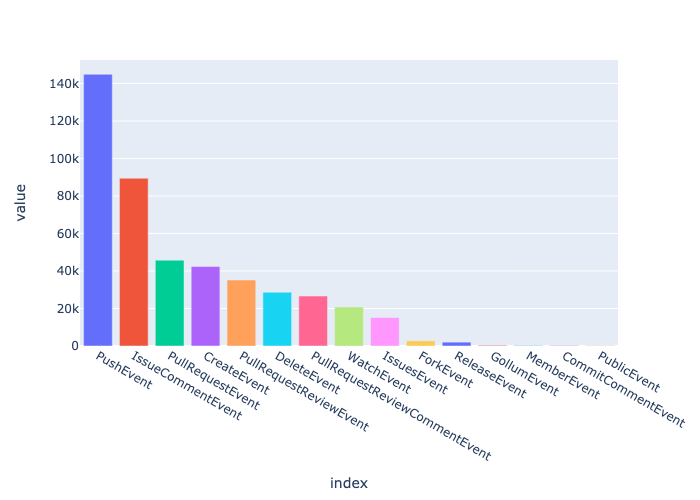

In [291]:
Image("knowncontributors_eventcount.png")

## Most common repositories among known contributors

In [292]:
kc_repo_event_counts = df_known_event_stream.repo_git.value_counts()
df_fig_rec_kc = kc_repo_event_counts.to_frame() 

fig_rec_kc = px.bar(
    data_frame=df_fig_rec_kc[:50],
    color=df_fig_rec_kc[:50].index,
)
fig_rec_kc.update_layout(showlegend=False)
fig_rec_kc.write_image("knowncontributors_repository_eventcount.png")
fig_rec_kc

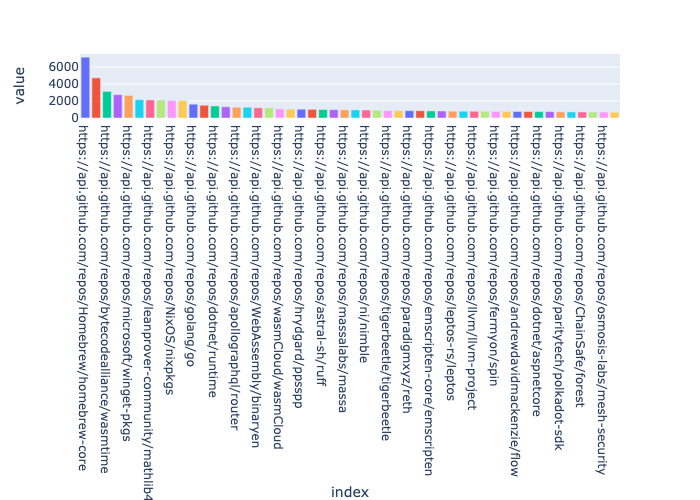

In [293]:
Image("knowncontributors_repository_eventcount.png")

## Interpretation

We find here that some obvious WASM-specific repositories are contributed to most frequently by the contributors we already knew about.

However, as one might expect, repos that are popular among the general public like 'risingwavelabs/risingwave', (which is 5th in this list and 74th among the general population, despite being a distributed streaming DB (not about WASM))
are also popular among this slice of the general population.

Our challenge now is to find those repos that are *especially* popular among this population as compared to the popularity among the general public.

# Identify disproportionately popular repos

## Unknown contributors

We want to consider the popularity of repos among people who aren't in our initial set.

If our 'known' group of contributors is the subpopulation "p" and the general population is "P",
then the group of people who are in the general population but aren't in our sub-population is "P - p" or " P^ ", pronounced P-hat.

In [294]:
# Get events made by those in P^

df_general_event_stream = df_event_stream[~df_event_stream.cntrb_id.isin(UUID_known)]
df_general_event_stream.shape

(3788650, 8)

In [295]:
# Count the events-per-repo of P^

g_repo_event_counts = df_general_event_stream.repo_git.value_counts().to_frame()
g_repo_event_counts

,repo_git
https://api.github.com/repos/llvm/llvm-project,48520
https://api.github.com/repos/JetBrains/MPS,14522
https://api.github.com/repos/pytorch/pytorch,14015
https://api.github.com/repos/dotnet/runtime,12700
https://api.github.com/repos/milahu/opensubtitles-scraper-new-subs,11358
...,...
https://api.github.com/repos/joachimneu/regenbib,1
https://api.github.com/repos/jenkinsci/ssh-agent-plugin,1
https://api.github.com/repos/Wohlstand/OPNMIDI-Player-Java,1
https://api.github.com/repos/mrlacey/VSWaterMark,1


In [296]:
# Join the counts of P^ with those of p

joined_counts = g_repo_event_counts.join(
    other=kc_repo_event_counts.to_frame(),
    how="left",
    lsuffix="_general",
    rsuffix="_known",
)

joined_counts = joined_counts.rename(columns={"repo_git_general": "count_general", "repo_git_known": "count_known"})

joined_counts = joined_counts.dropna()
joined_counts

,count_general,count_known
https://api.github.com/repos/llvm/llvm-project,48520,795.0
https://api.github.com/repos/pytorch/pytorch,14015,9.0
https://api.github.com/repos/dotnet/runtime,12700,1415.0
https://api.github.com/repos/apple/swift,10801,134.0
https://api.github.com/repos/rust-lang/rust,8805,4716.0
...,...,...
https://api.github.com/repos/jdtsmith/indent-bars,1,4.0
https://api.github.com/repos/vinceliuice/Graphite-kde-theme,1,1.0
https://api.github.com/repos/kubewarden/docs,1,40.0
https://api.github.com/repos/ashutosh1919/masterPortfolio,1,1.0


## Simple approach

In this figure we visualize the count of contributions from those in 'p' and 'P^' stacked on top of one another. 

Most of the most-contributed-to projects of those in 'p' are also most-contributed-to by members of 'p' (they are not also largely contributed to by those in 'P^').

Some notable visual exceptions are 'NixOS/nixpkgs,' 'dotnet/runtime,' 'astral-sh/ruff,' 'paritytech/substrate,' and 'llvm/llvm-project.'

In [297]:
fig_joined_counts = px.bar(
    data_frame=joined_counts
    .sort_values(by="count_known", ascending=False) # sort the joined_counts df by the number of contributions made by those in p
    [:50], # only take the first 50
    y=["count_general", "count_known"],
)
fig_joined_counts.update_layout(showlegend=False)
fig_joined_counts.write_image("joined_counts.png")
fig_joined_counts

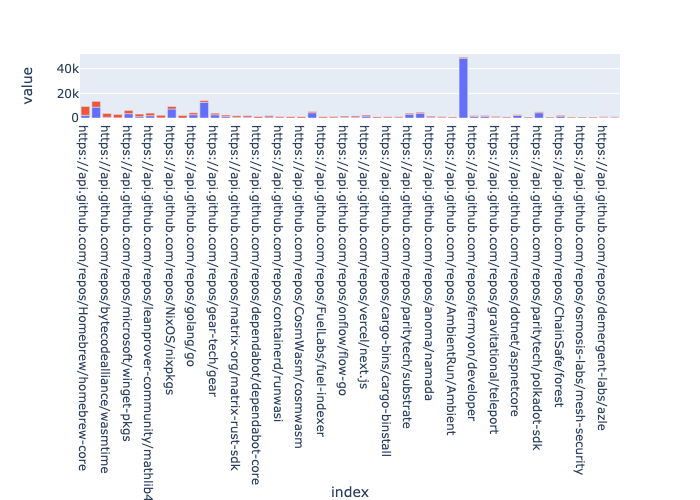

In [298]:
Image("joined_counts.png")